### Subtour Elimination using MTZ

In [16]:
import networkx as nx
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import csv

def read_graph(filename="graph_data.csv"):
    edges = {}
    nodes = set()
    with open(filename, "r") as f:
        reader = csv.reader(f)
        next(reader)  # Skip header
        for row in reader:
            u, v, weight = row[0], row[1], int(row[2])
            edges[(u, v)] = weight
            nodes.add(u)
            nodes.add(v)
    # Sort nodes by numeric suffix (compatible with program2's sorting)
    try:
        nodes = sorted(nodes, key=lambda x: int(x[1:]))
    except ValueError:
        # Fallback to lexicographical order if numeric sorting fails
        nodes = sorted(nodes)
    return edges, nodes

# Read graph from CSV
edges, nodes = read_graph()
source = nodes[0]
target = nodes[-1]

# Create ILP model
m = gp.Model()

# Variables: x[u,v] indicates if edge (u,v) is used
x = {(u, v): m.addVar(vtype=GRB.BINARY, name=f"x_{u}_{v}") for u, v in edges}

# MTZ position variables (exclude source)
u_pos = {i: m.addVar(lb=0, ub=len(nodes)-1, vtype=GRB.INTEGER, name=f"u_pos_{i}") 
          for i in nodes if i != source}

# Objective: Minimize total weight
m.setObjective(gp.quicksum(x[u, v] * edges[(u, v)] for u, v in edges), GRB.MINIMIZE)

# Constraints
# 1. Source has one outgoing edge
m.addConstr(gp.quicksum(x[source, v] for v in nodes if (source, v) in edges) == 1, "c1")

# 2. Target has one incoming edge
m.addConstr(gp.quicksum(x[u, target] for u in nodes if (u, target) in edges) == 1, "c2")

# 3. Flow conservation and degree constraints for intermediate nodes
for p in nodes:
    if p not in [source, target]:
        m.addConstr(
            gp.quicksum(x[p, q] for q in nodes if (p, q) in edges) -
            gp.quicksum(x[r, p] for r in nodes if (r, p) in edges) == 0,
            f"flow_{p}"
        )
        m.addConstr(gp.quicksum(x[p, q] for q in nodes if (p, q) in edges) <= 1, f"out_deg_{p}")
        m.addConstr(gp.quicksum(x[r, p] for r in nodes if (r, p) in edges) <= 1, f"in_deg_{p}")

# MTZ constraints to prevent subtours
for i in nodes:
    for j in nodes:
        if i != source and j != source and i != j and (i, j) in edges:
            m.addConstr(u_pos[i] - u_pos[j] + len(nodes)*x[i, j] <= len(nodes)-1, f"mtz_{i}_{j}")

# Set target's position to last
m.addConstr(u_pos[target] == len(nodes) - 1, "pos_target")

# Solve the model
m.optimize()

# Process and print results
if m.status == GRB.OPTIMAL:
    path_edges = [(u, v) for u, v in edges if x[u, v].X > 0.5]
    solution_edges = {u: v for u, v in path_edges}
    
    # Reconstruct the ordered path
    current_node = source
    ordered_path = [current_node]
    while current_node in solution_edges:
        current_node = solution_edges[current_node]
        ordered_path.append(current_node)
    
    print("Best Path (ILP Optimal Solution):")
    print(" -> ".join(ordered_path))
    print(f"Total Weight: {m.objVal}")
    
    # Optional: Plot the graph with the path highlighted
    # G = nx.DiGraph()
    # G.add_weighted_edges_from((u, v, w) for (u, v), w in edges.items())
    # pos = nx.spring_layout(G)
    # nx.draw(G, pos, with_labels=True, node_size=700, node_color="lightblue", arrowsize=20)
    # nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=2)
    # edge_labels = {(u, v): w for (u, v), w in edges.items()}
    # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    #plt.title(f"Optimal Path: Total Weight = {m.objVal}")
    #plt.show()
else:
    print("No optimal solution found.")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: AMD Ryzen 3 3250U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 183 rows, 129 columns and 674 nonzeros
Model fingerprint: 0x71dfd08d
Variable types: 0 continuous, 129 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective -4.0000000
Presolve removed 29 rows and 13 columns
Presolve time: 0.00s
Presolved: 154 rows, 116 columns, 603 nonzeros
Variable types: 0 continuous, 116 integer (90 binary)

Root relaxation: objective -4.933333e+01, 61 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

 

In [10]:
# import networkx as nx
# import matplotlib.pyplot as plt
# import gurobipy as gp
# from gurobipy import GRB

# # Define the graph
# nodes = ['s', 'a', 'b', 'c', 't', 'x', 'y', 'z']
# edges = {
#     ('s', 'a'): 3,
#     ('a', 'b'): -3,
#     ('a', 'c'): 2,
#     ('c', 'b'): -6,
#     ('b', 't'): 4,
#     ('x', 'y'): -30,
#     ('y', 'z'): -40,
#     ('z', 'x'): -50,
# }

# # Create a new model
# m = gp.Model()

# # Create variables
# x = {}
# for u, v in edges:
#     x[u, v] = m.addVar(vtype=GRB.BINARY, name=f"x_{u}_{v}")

# # Create MTZ position variables (excluding source node)
# u_pos = {}
# for i in nodes:
#     if i != 's':  # Exclude source node
#         u_pos[i] = m.addVar(lb=0, ub=len(nodes)-1, vtype=GRB.INTEGER, name=f"u_pos_{i}")

# # Set objective function
# m.setObjective(gp.quicksum(x[u, v] * edges[u, v] for u, v in edges), GRB.MINIMIZE)

# # Add constraints
# # Constraint 1: The number of edges leaving 's' is 1
# m.addConstr(gp.quicksum(x['s', v] for v in nodes if ('s', v) in edges) == 1, "c1")

# # Constraint 2: The number of edges entering 't' is 1
# m.addConstr(gp.quicksum(x[u, 't'] for u in nodes if (u, 't') in edges) == 1, "c2")

# # Constraint 3: Flow conservation and degree constraints for intermediate nodes
# for p in nodes:
#     if p not in ['s', 't']:
#         # Flow conservation
#         m.addConstr(
#             gp.quicksum(x[p, q] for q in nodes if (p, q) in edges) -
#             gp.quicksum(x[r, p] for r in nodes if (r, p) in edges) == 0,
#             f"flow_{p}"
#         )
#         # Degree constraints
#         m.addConstr(gp.quicksum(x[p, q] for q in nodes if (p, q) in edges) <= 1, f"out_degree_{p}")
#         m.addConstr(gp.quicksum(x[r, p] for r in nodes if (r, p) in edges) <= 1, f"in_degree_{p}")

# # Add MTZ subtour elimination constraints
# for i in nodes:
#     for j in nodes:
#         if i != 's' and j != 's' and i != j and (i, j) in edges:
#             # If edge (i,j) is used, j's position must be greater than i's position
#             m.addConstr(u_pos[i] - u_pos[j] + len(nodes) * x[i, j] <= len(nodes) - 1, f"mtz_{i}_{j}")

# # Set position of terminal node to be last
# m.addConstr(u_pos['t'] == len(nodes) - 1, "terminal_position")

# # Solve the model
# m.optimize()

# # Plot the graph and the path taken
# G = nx.DiGraph()
# G.add_weighted_edges_from((u, v, edges[u, v]) for u, v in edges)
# pos = nx.spring_layout(G)

# # Draw the graph
# nx.draw(G, pos, with_labels=True, node_size=700, node_color="lightblue", arrowsize=20)
# edge_labels = {(u, v): edges[u, v] for u, v in edges}
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# # Highlight the path taken and print positions
# if m.status == GRB.OPTIMAL:
#     path_edges = [(u, v) for u, v in edges if x[u, v].X > 0.5]
#     nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=1.5)
#     plt.title(f"Optimal objective value: {m.objVal}")
    
#     # Print the positions of nodes in the solution path
#     print("\nNode positions in the path:")
#     for node in nodes:
#         if node != 's':
#             if any(x[u, v].X > 0.5 for u, v in edges if u == node or v == node):
#                 print(f"Position of {node}: {u_pos[node].X}")
    
#     plt.show()
# else:
#     print("No optimal solution found.")

### ---------------------------------------------------------------------------------------------------------------------------

### Subtour Elimination using DFJ

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 24.04.1 LTS")

CPU model: AMD Ryzen 3 3250U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 20 rows, 8 columns and 30 nonzeros
Model fingerprint: 0x3bbf81ba
Variable types: 0 continuous, 8 integer (8 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 0 rows, 2 columns, 0 nonzeros
Variable types: 0 continuous, 2 integer (2 binary)

Root relaxation: objective 3.000000e+00, 0 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               

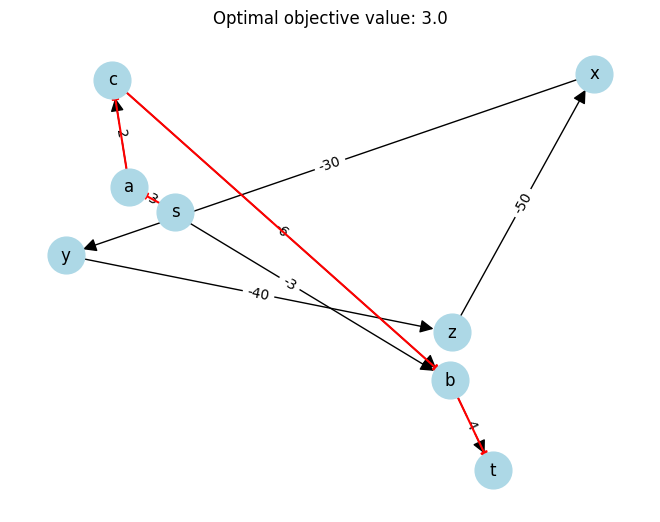

In [2]:
# import networkx as nx
# import matplotlib.pyplot as plt
# import gurobipy as gp
# from gurobipy import GRB
# from itertools import combinations

# def find_subtours(solution_dict):
#     """Find subtours in the current solution"""
#     # Create a graph from selected edges
#     G = nx.DiGraph()
#     for (u, v) in solution_dict:
#         if solution_dict[u, v] > 0.5:
#             G.add_edge(u, v)
    
#     # Find strongly connected components (subtours)
#     subtours = list(nx.strongly_connected_components(G))
#     return [list(tour) for tour in subtours if len(tour) >= 2]

# def subtour_elimination_callback(model, where):
#     """Callback to add subtour elimination constraints"""
#     if where == GRB.Callback.MIPSOL:
#         # Get the current solution
#         solution_dict = {}
#         for (u, v) in edges:
#             solution_dict[u, v] = model.cbGetSolution(model._vars[u, v])
        
#         # Find subtours
#         subtours = find_subtours(solution_dict)
        
#         # Add constraints for each subtour
#         for tour in subtours:
#             if 's' not in tour and 't' not in tour:  # Only eliminate subtours not containing s or t
#                 tour_edges = [(i, j) for i, j in edges if i in tour and j in tour]
#                 if tour_edges:
#                     model.cbLazy(gp.quicksum(model._vars[i, j] for i, j in tour_edges) <= len(tour) - 1)

# # Define the graph
# nodes = ['s', 'a', 'b', 'c', 't', 'x', 'y', 'z']
# edges = {
#     ('s', 'a'): 3,
#     ('a', 'b'): -3,
#     ('a', 'c'): 2,
#     ('c', 'b'): -6,
#     ('b', 't'): 4,
#     ('x', 'y'): -30,
#     ('y', 'z'): -40,
#     ('z', 'x'): -50,
# }

# # Create a new model with lazy constraints enabled
# m = gp.Model()
# m.Params.lazyConstraints = 1

# # Create variables
# x = {}
# for u, v in edges:
#     x[u, v] = m.addVar(vtype=GRB.BINARY, name=f"x_{u}_{v}")

# # Store variables in model for callback access
# m._vars = x

# # Set objective function
# m.setObjective(gp.quicksum(x[u, v] * edges[u, v] for u, v in edges), GRB.MINIMIZE)

# # Add constraints
# # Constraint 1: The number of edges leaving 's' is 1
# m.addConstr(gp.quicksum(x['s', v] for v in nodes if ('s', v) in edges) == 1, "c1")

# # Constraint 2: The number of edges entering 't' is 1
# m.addConstr(gp.quicksum(x[u, 't'] for u in nodes if (u, 't') in edges) == 1, "c2")

# # Constraint 3: Flow conservation for intermediate nodes
# for p in nodes:
#     if p not in ['s', 't']:
#         m.addConstr(
#             gp.quicksum(x[p, q] for q in nodes if (p, q) in edges) -
#             gp.quicksum(x[r, p] for r in nodes if (r, p) in edges) == 0,
#             f"flow_{p}"
#         )
#         # Degree constraints
#         m.addConstr(gp.quicksum(x[p, q] for q in nodes if (p, q) in edges) <= 1, f"out_degree_{p}")
#         m.addConstr(gp.quicksum(x[r, p] for r in nodes if (r, p) in edges) <= 1, f"in_degree_{p}")

# # Set the callback
# m.optimize(subtour_elimination_callback)

# # Plot the graph and the path taken
# G = nx.DiGraph()
# G.add_weighted_edges_from((u, v, edges[u, v]) for u, v in edges)
# pos = nx.spring_layout(G)

# # Draw the graph
# nx.draw(G, pos, with_labels=True, node_size=700, node_color="lightblue", arrowsize=20)
# edge_labels = {(u, v): edges[u, v] for u, v in edges}
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# # Highlight the path taken
# if m.status == GRB.OPTIMAL:
#     path_edges = [(u, v) for u, v in edges if x[u, v].X > 0.5]
#     nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=1.5)
    
#     # Print the path and its cost
#     print("\nOptimal path:")
#     for u, v in path_edges:
#         print(f"{u} -> {v} (cost: {edges[u, v]})")
#     print(f"\nTotal cost: {m.objVal}")
    
#     plt.title(f"Optimal objective value: {m.objVal}")
#     plt.show()
# else:
#     print("No optimal solution found.")